In [13]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import MC
import time
import pickle
import datetime
import Sensor
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def runTest():
    t1 = time.perf_counter()
    ret = MC.lunchPacketwithBatch(batchSize = 1e7,
                               nPhotonsRequested = 1e7,
                                nPhotonsToRun = 1e7,
                                muS = 1.0, g = 0.85,
                                source = {'r': np.array([0.0, 0.0, 30.0]),
                                          'mu': np.array([0.0, 0.0, -1.0]),
                                          'method': 'pencil', 'time_profile': 'delta'},
                                detector = {'radius': 100.0},
                                control_param = {'max_N': 1e5,
                                                 'max_distance_from_det': 110},
                                normalize_d = None,
                                ret_cols = [0,1,2,3,4,5,6,7]
                                )
    print(ret[1], ret[2], time.perf_counter()-t1)
    ds = {'data': ret[0],
          'num_simulated': ret[1],
          'num_detected': ret[2]}
    with open('testdata.pickle', 'wb') as handle:
        pickle.dump(ds, handle)  
        
        
def runTargetTest():
    t1 = time.perf_counter()
    target_mask = np.zeros(shape=(60,60))
    target_mask[21:50,28:32]=1
    #target_mask[15:45,15:19]=1
    target_mask[16:21,15:45]=1
    target_gridsize = np.array([1,1])
    target_distance_from_camera = 10
    
    ret = MC.lunchPacketwithBatch(batchSize = 1e7,
                               nPhotonsRequested = 1e7,
                                nPhotonsToRun = 1e7,
                                muS = 1.0, g = 0.85,
                                source = {'r': np.array([0.0, 0.0, 30.0]),
                                          'mu': np.array([0.0, 0.0, -1.0]),
                                          'method': 'pencil', 'time_profile': 'delta'},
                                detector = {'radius': 100.0},
                                control_param = {'max_N': 1e5,
                                                 'max_distance_from_det': 110},
                                normalize_d = None,
                                ret_cols = [0,1,2,3,4,5,6,7],
                                target = {'type':1,
                                'mask':target_mask,
                                'grid_size':target_gridsize,
                                'z_target':target_distance_from_camera}
                                )
    print(ret[1], ret[2], time.perf_counter()-t1)
    ds = {'data': ret[0],
          'num_simulated': ret[1],
          'num_detected': ret[2]}
    with open('testdata.pickle', 'wb') as handle:
        pickle.dump(ds, handle)  
        
        
def runScatteringTargetTest():
    t1 = time.perf_counter()
    target_mask = np.zeros(shape=(60,60))
    target_mask[25:35, 25:35]=1
    target_gridsize = np.array([1,1])
    target_distance_from_camera = 20
    
    ret = MC.lunchPacketwithBatch(batchSize = 1e6,
                               nPhotonsRequested = 1e6,
                                nPhotonsToRun = 1e6,
                                muS = 0.5, g = 0.85,
                                source = {'r': np.array([0.0, 0.0, 0.0]),
                                          'mu': np.array([0.0, 0.0, 1.0]),
                                          'method': 'pencil', 'time_profile': 'delta'},
                                detector = {'radius': 100.0},
                                control_param = {'max_N': 1e5,
                                                 'max_distance_from_det': 110},
                                normalize_d = None,
                                ret_cols = [0,1,2,3,4,5,6,7, 8, 9],
                                target = {'type':2,
                                'mask':target_mask,
                                'grid_size':target_gridsize,
                                'z_target':target_distance_from_camera}
                                )
    print(ret[1], ret[2], time.perf_counter()-t1)
    ds = {'data': ret[0],
          'num_simulated': ret[1],
          'num_detected': ret[2]}
    with open('testdata.pickle', 'wb') as handle:
        pickle.dump(ds, handle)  
        
        
def loadTest():
    with open('testdata.pickle', 'rb') as handle:
        ds = pickle.load(handle)

    data = ds['data']
    num_simulated = ds['num_simulated']
    num_detected = ds['num_detected']

    return data, num_simulated, num_detected


def plotTest(data):
    plt.figure(figsize=(20,7))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.hist(data[:,i], bins=100)
    plt.show()
        
        
def plotTargetTest(data):
    data = data[:,[2,3,0]]
    measurement = Sensor.photonsTo3DMeasurement(data,camera = {'center': [0,0],'dim':[64,64],
                                                                'pixel_size':1, 'time_res':50,
                                                                'time_bin':100})
    measurement_xy = np.sum(measurement,axis=2)
    measurement_xt = np.sum(measurement,axis=0)
    ft = np.sum(measurement_xt,axis=0)
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.imshow(measurement_xy)
    plt.subplot(132)
    plt.imshow(measurement_xt)
    plt.subplot(133)
    plt.plot(ft)
    plt.show()
        

def plotScatteringTargetTest(data):
    data_ = data[data[:,8]<=0, :]
    plt.figure(figsize=(20,7))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.hist(data_[:,i], bins=100)
    plt.show()    
    background = data_.shape[0]
    
    data_ = data[data[:,8]>0, :]
    plt.figure(figsize=(20,10))
    for i in range(10):
        plt.subplot(3, 4, i+1)
        plt.hist(data_[:,i], bins=100)
    plt.subplot(3,4,11)
    plt.hist(data_[:,0] - data_[:,8], bins=100)
    plt.show()   
    signal = data_.shape[0]
    print('Background: ' + str(background) + ', Signal: ' + str(signal) + ', Ratio: ' + str(signal/background))
    n_post = (data_[:,0] - data_[:,8]).astype(int)
    n_post_vals = np.unique(np.sort(n_post))
    hist__ = np.zeros(shape=(n_post_vals.size, 2), dtype=int)
    for i, v in enumerate(n_post_vals):
        hist__[i, 0] = v
        hist__[i, 1] = np.sum(n_post == v)
    print(hist__)
    
    n_post = (data_[:,8]).astype(int)
    n_post_vals = np.unique(np.sort(n_post))
    hist__ = np.zeros(shape=(n_post_vals.size, 2), dtype=int)
    for i, v in enumerate(n_post_vals):
        hist__[i, 0] = v
        hist__[i, 1] = np.sum(n_post == v)
    print(hist__)    
    #print(data_)


def testRun():
    print(datetime.datetime.now())
    runTest()
    data, num_simulated, num_detected = loadTest()
    plotTest(data)


def testRunTarget():
    print(datetime.datetime.now())
    runTargetTest()
    data, num_simulated, num_detected = loadTest()
    plotTargetTest(data)

    
def testRunScatteringTarget():
    print(datetime.datetime.now())
    runScatteringTargetTest()
    data, num_simulated, num_detected = loadTest()
    plotScatteringTargetTest(data)    
    return data


2019-02-06 11:09:07.739204
10000000 6474580 15.856996188056655
10000000 6474580 15.857190351001918


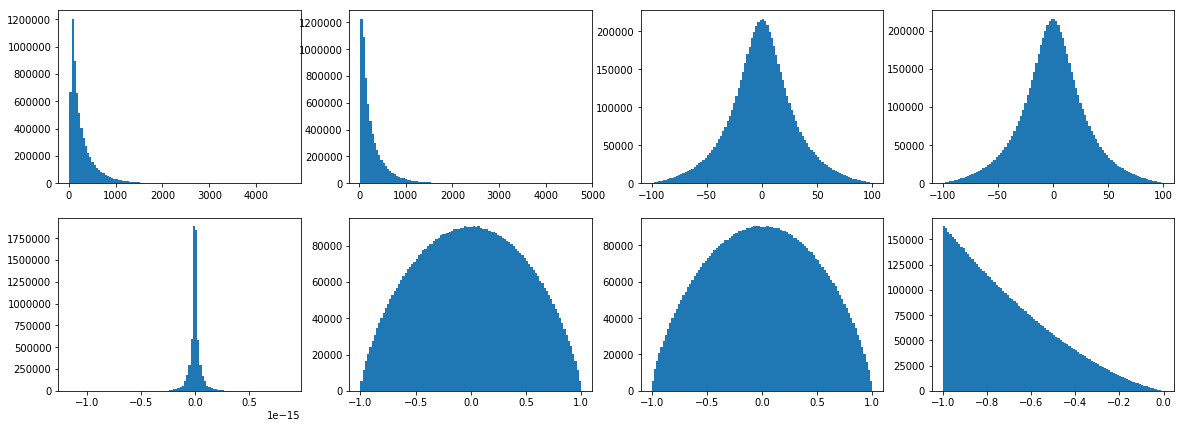

In [20]:
testRun()

#### Test after adding 2D target simulation feature

2019-02-08 08:43:38.273410
10000000 6475339 18.96151531697251


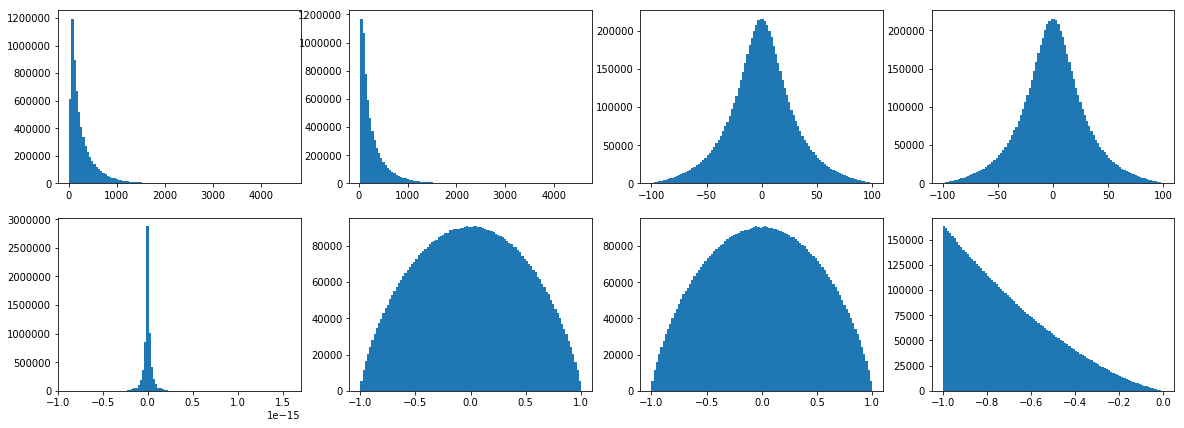

In [4]:
testRun()

2019-02-08 08:45:03.655209
10000000 420874 15.35326342494227


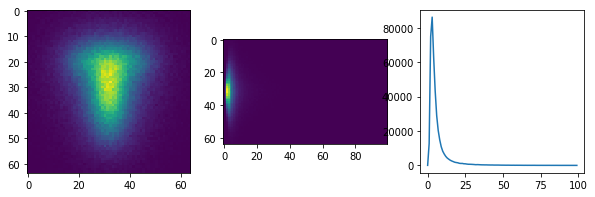

In [5]:
testRunTarget()

2019-02-11 13:21:59.209123
10000000 6476814 17.32187145401258


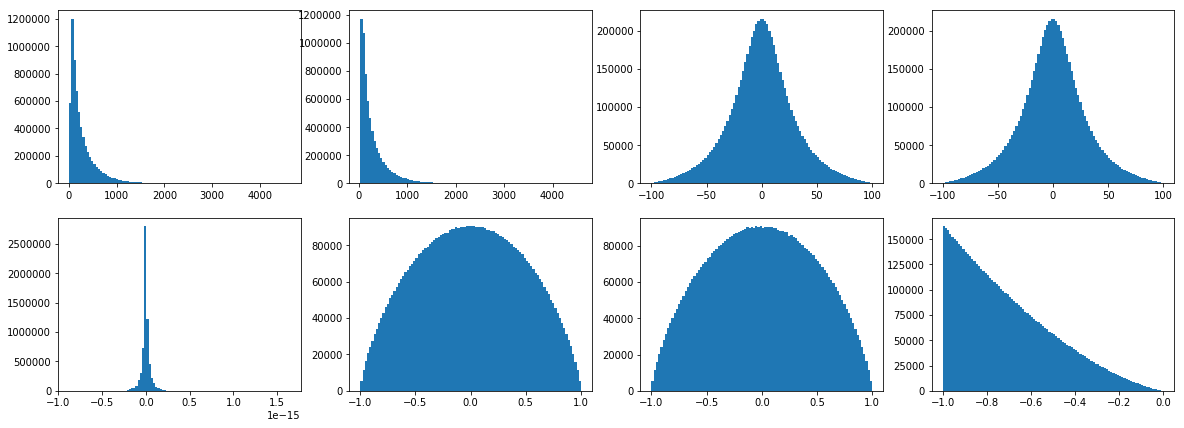

2019-02-11 13:22:22.081988
10000000 421465 15.736091538972687


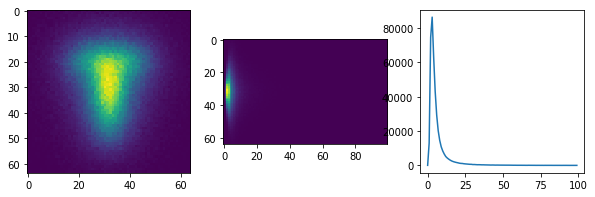

NameError: name 'testRunScatteringTarget' is not defined

In [32]:
testRun()
testRunTarget()
testRunScatteringTarget()


2019-02-12 13:08:12.113553
1000000 795164 4.131060234999495


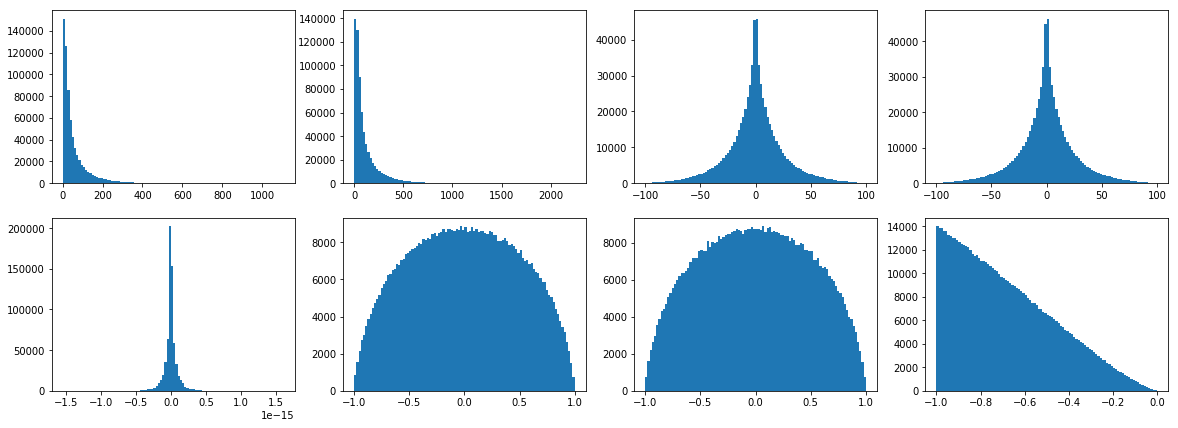

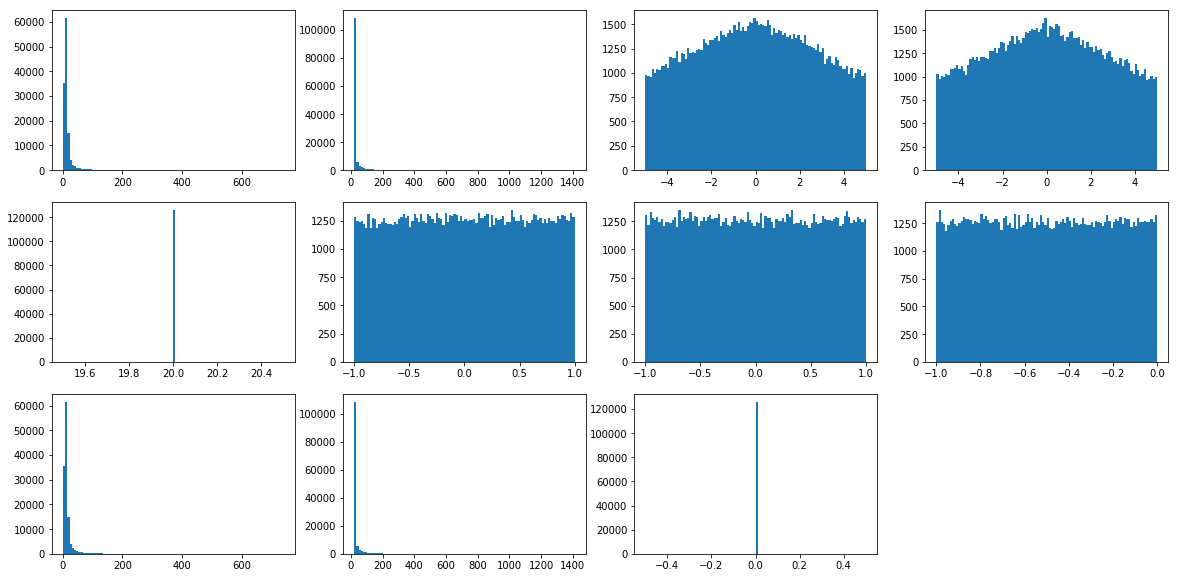

Background: 669019, Signal: 126145, Ratio: 0.18855219358493555
[[     0 126145]]
[[    1    53]
 [    2   294]
 [    3  1018]
 [    4  2519]
 [    5  4514]
 [    6  6898]
 [    7  9291]
 [    8 10784]
 [    9 11628]
 [   10 11504]
 [   11 10573]
 [   12  9277]
 [   13  7708]
 [   14  6150]
 [   15  4778]
 [   16  3759]
 [   17  2861]
 [   18  2272]
 [   19  1726]
 [   20  1410]
 [   21  1185]
 [   22  1014]
 [   23   778]
 [   24   741]
 [   25   630]
 [   26   647]
 [   27   519]
 [   28   494]
 [   29   476]
 [   30   409]
 [   31   377]
 [   32   361]
 [   33   344]
 [   34   316]
 [   35   293]
 [   36   278]
 [   37   259]
 [   38   228]
 [   39   243]
 [   40   239]
 [   41   221]
 [   42   205]
 [   43   187]
 [   44   198]
 [   45   175]
 [   46   188]
 [   47   161]
 [   48   125]
 [   49   156]
 [   50   149]
 [   51   152]
 [   52   111]
 [   53   122]
 [   54   109]
 [   55   116]
 [   56   124]
 [   57   116]
 [   58    97]
 [   59    94]
 [   60   119]
 [   61   100]
 [  

In [15]:
data = testRunScatteringTarget()

[[    0    51]
 [    2     2]
 [    3     1]
 ...
 [99987     1]
 [99988     1]
 [99995     2]]


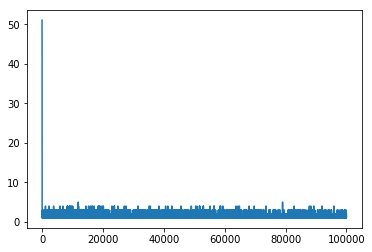

In [5]:
data_ = data[data[:,8]>0, :]
n_post = (data_[:,8]).astype(int)
n_post_vals = np.unique(np.sort(n_post))
hist__ = np.zeros(shape=(n_post_vals.size, 2), dtype=int)
for i, v in enumerate(n_post_vals):
    hist__[i, 0] = v
    hist__[i, 1] = np.sum(n_post == v)

print(hist__)    
plt.plot(hist__[:,0], hist__[:,1])

(array([56.,  4.,  2., ...,  1.,  2.,  4.]),
 array([0.00000000e+00, 9.99950000e+00, 1.99990000e+01, ...,
        9.99750010e+04, 9.99850005e+04, 9.99950000e+04]),
 <a list of 10000 Patch objects>)

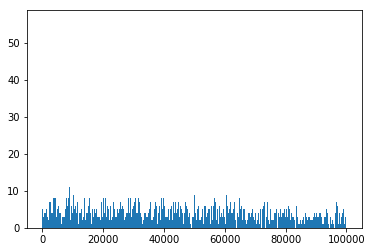

In [12]:
plt.figure()
plt.hist(data[data[:,8]>0, 8].astype(int), bins=10000)